# Bounds on the Ergodic Secret-Key Capacity for Dependent Fading Channels

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig

This notebook is part of the paper "Bounds on the Ergodic Secret-Key Capacity for Dependent Fading Channels" ([https://ieeexplore.ieee.org/document/9097120](https://ieeexplore.ieee.org/document/9097120)).  
If you use any of this work, please cite the above paper.

# Scenario

We consider the wiretap channel with Rayleigh fading.

The secret key capacity is given as
$$C_{s}(X, Y) = \log_2\left(\frac{1 + \alpha X + \beta Y}{1 + \beta Y}\right)$$

The receive signals X and Y are, due to fading, exponentially distributed, i.e., $X\sim\exp(\lambda_{x})$ and $Y\sim\exp(\lambda_{y})$.

# Results

In the following, the upper and lower bound on the secret-key capacity are presented. For comparison, the iid case is also given.
The derivations can be found in the paper "*Bounds on the Ergodic Secret-Key Capacity for Dependent Fading Channels*" (Karl-Ludwig Besser and Eduard Jorswieck, 24th International ITG Workshop on Smart Antennas, 2020).

In [1]:
import numpy as np
from scipy import integrate
from scipy.special import expi
from scipy import stats
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
def inv_cdf(u, lam=1):
    return -np.log(1-u)/lam

def capacity(x, y, a=1, b=1):
    return np.log2((1 + a*x + b*y)/(1+b*y))

In [3]:
def independent_capacity(lam_x=1, lam_y=1, a=1, b=1):
    _part1 = np.exp(lam_y/b)*expi(-lam_y/b)
    if lam_x/a == lam_y/b:
        _part2 = (-a + np.exp(lam_x/a)*(a-lam_x)*expi(-lam_x/a))/a
    else:
        _part2 = (a*np.exp(lam_x/a)*lam_y*expi(-lam_x/a)-b*np.exp(lam_y/b)*lam_x*expi(-lam_y/b))/(a*lam_y-b*lam_x)
    return (_part1 - _part2)/np.log(2)

def lower_bound(lam_x=1, lam_y=1, a=1, b=1):
    _part1 = np.exp(lam_y/b)*expi(-lam_y/b)
    _part2 = np.exp((lam_x*lam_y)/(a*lam_y+b*lam_x))*expi(-(lam_x*lam_y)/(a*lam_y+b*lam_x))
    return (_part1 - _part2)/np.log(2)

def upper_bound(lam_x=1, lam_y=1, a=1, b=1):
    def cost_func(u, lam_x=1, lam_y=1, a=1, b=1):
        return capacity(inv_cdf(u, lam=lam_x), inv_cdf(1.-u, lam=lam_y), a=a, b=b)
    expected = integrate.quad(cost_func, 0, 1, args=(lam_x, lam_y, a, b))
    return expected[0]

In [4]:
def calc_expected(snr_db_bob, snr_db_eve, bound='min', lam_x=1, lam_y=1):
    snr_lin_a = 10**(snr_db_bob/10.)
    snr_lin_b = 10**(snr_db_eve/10.)
    if bound == 'iid':
        value = independent_capacity(lam_x=lam_x, lam_y=lam_y, a=snr_lin_a, b=snr_lin_b)
    elif bound == "lower":
        value = lower_bound(lam_x=lam_x, lam_y=lam_y, a=snr_lin_a, b=snr_lin_b)
    elif bound == "upper":
        value = upper_bound(lam_x=lam_x, lam_y=lam_y, a=snr_lin_a, b=snr_lin_b)
    return np.maximum(value, 0)

<IPython.core.display.Javascript object>


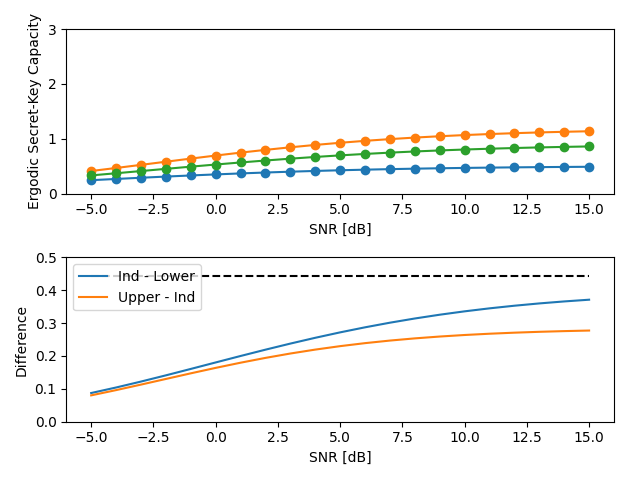

interactive(children=(FloatSlider(value=1.0, description='lam_x', max=3.0, min=0.1), FloatSlider(value=1.0, de…

In [5]:
def export_results(results, outdir='.'):
    with open('results.dat', 'w') as f:
        f.write('{}\n'.format('\t'.join(results.keys())))
        for row in zip(*results.values()):
            f.write('{}\n'.format('\t'.join([str(a) for a in row])))

def capacity_plot():
    fig, ax = plt.subplots(2, 1, num="Ergodic Secret-Key Capacity")
    ax[0].set_xlabel("SNR [dB]")
    ax[0].set_ylabel("Ergodic Secret-Key Capacity")
    ax[0].set_ylim([0, 3])
    ax[1].set_xlabel("SNR [dB]")
    ax[1].set_ylabel("Difference")
    ax[1].set_ylim([0, 0.5])
    fig.tight_layout()
    plots = {}
    snr_db = np.arange(-5, 16)
    keys = ['lower', 'upper', 'iid']
    data = {'snr': snr_db}
    for _key in keys:
        results = [calc_expected(snr, snr, _key, lam_x=1, lam_y=1) for snr in snr_db]
        data[_key] = np.array(results)
        plots[_key] = ax[0].plot(snr_db, results, 'o-')[0]
    data['diffLI'] = data['iid'] - data['lower']
    data['diffUI'] = data['upper'] - data['iid']
    plot_diffLI = ax[1].plot(snr_db, data['diffLI'], label="Ind - Lower")[0]
    plot_diffUI = ax[1].plot(snr_db, data['diffUI'], label="Upper - Ind")[0]
    ax[1].hlines(1./np.log(2)-1, min(snr_db), max(snr_db), ls='dashed')
    plt.legend()
    export_results(data)
    
    def update_plot(lam_x=1, lam_y=1):
        for _key, _plot in plots.items():
            data[_key] = np.array([calc_expected(snr, snr, _key, lam_x=lam_x, lam_y=lam_y) for snr in snr_db])
            _plot.set_ydata(data[_key])
        plot_diffLI.set_ydata(data['iid'] - data['lower'])
        plot_diffUI.set_ydata(data['upper'] - data['iid'])
        fig.canvas.draw_idle()
    
    interact(update_plot, lam_x=(.1, 3., .1), lam_y=(.25, 5., .25))

capacity_plot()